# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization, Attention, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import Input, LSTM, Dense, Concatenate, Dot, Activation
from keras.layers import RepeatVector, TimeDistributed
from keras.models import Model



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Dataset

In [2]:
Crema = "/kaggle/input/cremad/AudioWAV/"

In [3]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1,happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2,happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3,disgust,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4,disgust,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav


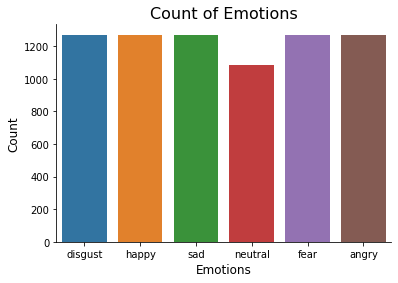

In [4]:
plt.title('Count of Emotions', size=16)
sns.countplot(Crema_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Visualization

In [5]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

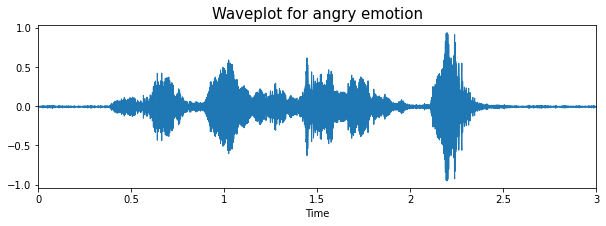

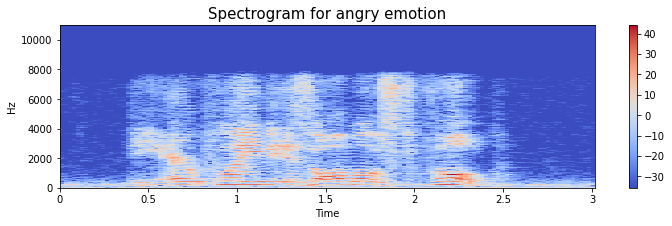

In [6]:
emotion='angry'
path = np.array(Crema_df.Path[Crema_df.Emotions==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# MFCC Extraction

In [7]:
labels = {'disgust':0,'happy':1,'sad':2,'neutral':3,'fear':4,'angry':5}
Crema_df.replace({'Emotions':labels},inplace=True)

In [8]:
num_mfcc=13
n_fft=2048
hop_length=512
SAMPLE_RATE = 22050
data = {
        "labels": [],
        "mfcc": []
    }
for i in range(7442):
    data['labels'].append(Crema_df.iloc[i,0])
    signal, sample_rate = librosa.load(Crema_df.iloc[i,1], sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
    mfcc = mfcc.T
    data["mfcc"].append(np.asarray(mfcc))
    if i%500==0:
        print(i)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


# Padding MFCC to make them of equal length

In [9]:
X = np.asarray(data['mfcc'])
y = np.asarray(data["labels"])

In [10]:
X = tf.keras.preprocessing.sequence.pad_sequences(X)
X.shape

(7442, 216, 13)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [12]:
print(X_train.shape,y_train.shape,X_validation.shape,y_validation.shape,X_test.shape,y_test.shape)

(5357, 216, 13) (5357,) (1340, 216, 13) (1340,) (745, 216, 13) (745,)


# Model

In [13]:
# lstm = tf.keras.layers.LSTM(64, return_sequences=True)(inputs)
def build_model(input_shape):
    model = tf.keras.Sequential()
    
    
#     lstm = tf.keras.layers.LSTM(output_dim)(inputs)
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
#     model.add(LSTM(64))
    model.add(tf.keras.layers.Attention((None, None, 128)))
#     attt = Attention()
#     model.add(attt)

    
#     print("Test Accuracy: ",test_acc)
#     lstm = tf.keras.layers.LSTM(output_dim)(inputs)
#     model.add(Attention((None, 64),64))   
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
#     model.add(Attention())
    model.add(Dense(6, activation='softmax'))
#     model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [14]:
# lstm = tf.keras.layers.LSTM(64, return_sequences=True)(inputs)
def build_model(input_shape):
    model = tf.keras.Sequential()
    
    
    lstm = tf.keras.layers.LSTM(128, input_shape=input_shape, return_sequences=True)
#     model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
#     model.add(LSTM(64))
#     print("Test Accuracy: ",test_acc)
#     lstm = tf.keras.layers.LSTM(output_dim)(inputs)
    attention = tf.keras.layers.Attention()([lstm, input_shape])
#     model.add(Attention((None, 64),64))   
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.3))
#     model.add(Attention())
    outputs = tf.keras.layers.Dense(6, activation='softmax')(attention)
#     model.add(Dense(6, activation='softmax'))
    model = tf.keras.Model(inputs=input_shape, outputs=outputs)
    return model

In [15]:
# lstm = tf.keras.layers.LSTM(64, return_sequences=True)(inputs)
def build_model(input_shape):
    
    
    lstm_layer = LSTM(128,input_shape = input_shape,return_sequences = True)
#     lstm_layer2 = LSTM(64,return_sequences=True)(lstm_layer)
    
    outputs = Dense(6, activation='softmax')(lstm_layer)
    print(lstm_layer)
    
    
#     attention = Attention()(lstm_layer)

    
    
    model = tf.keras.Model(input_shape,outputs)
    
    return model






In [16]:
inputs = Input(shape=(None,13))

# 添加LSTM层
lstm_out = LSTM(128, return_sequences=True)(inputs)
print(lstm_out)

KerasTensor(type_spec=TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), name='lstm/PartitionedCall:1', description="created by layer 'lstm'")


### doing

In [ ]:
from tensorflow.keras import layers, models

# 构建模型
input_data = layers.Input(shape=(None,13))
lstm_output = layers.LSTM(128, return_sequences=True)(input_data) # 添加一个LSTM层

lstm_output2 = layers.LSTM(64)(lstm_output)
query = layers.Dense(10)(lstm_output2) # 将LSTM的输出作为查询向量
value = layers.Dense(10)(lstm_output2) # 将LSTM的输出作为值向量

# 自注意力机制层
attention_output = layers.Attention()([query, value])

# 全连接层和分类输出层
flatten = layers.Flatten()(attention_output)
dense1 = layers.Dense(64, activation='relu')(flatten)
output = layers.Dense(6, activation='softmax')(dense1)

# 定义模型
model = models.Model(inputs=input_data, outputs=output)

# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

### 5.8

In [18]:
from tensorflow.keras import layers, models

# 构建模型
input_data = layers.Input(shape=(None,13))
lstm_output = layers.LSTM(128, return_sequences=True)(input_data)
CNN = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)

lstm_output2 = layers.LSTM(64)(lstm_output)
query = layers.Dense(10)(lstm_output2) # 将LSTM的输出作为查询向量
value = layers.Dense(10)(lstm_output2) # 将LSTM的输出作为值向量

# 自注意力机制层
attention_output = layers.Attention()([query, value])

# 全连接层和分类输出层
flatten = layers.Flatten()(attention_output)
dense1 = layers.Dense(64, activation='relu')(flatten)
output = layers.Dense(6, activation='softmax')(dense1)

# 定义模型
model = models.Model(inputs=input_data, outputs=output)

# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

SyntaxError: invalid syntax (<ipython-input-18-5f34d8038710>, line 8)

## 5.8-2

In [ ]:
from tensorflow.keras import layers, models

model = tf.keras.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(5357, 216, 13)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.Dense(128, activation='relu'))
# model.add(layers.LSTM(128, return_sequences=True))

model.summary()

In [ ]:
from tensorflow.keras import layers, models
inputs = Input(shape=(None,13))

xcxc = layers.Input(shape=(216, 13))

query = layers.Dense(10)(xcxc)
value = layers.Dense(10)(xcxc)

# 自注意力机制层

lstm_out = LSTM(128, return_sequences=True)(input_data)
# 全连接层和分类输出层
# flatten = layers.Flatten()(attention_output)

attention_output = layers.Attention()([query, value])

dense1 = layers.Dense(128, activation='relu')(lstm_out)

output = layers.Dense(6, activation='softmax')(dense1)



# 定义模型
model = models.Model(inputs=input_data, outputs=output)

# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()


In [ ]:
inputs = Input(shape=(None,13))

# 添加LSTM层
lstm_out = LSTM(128, return_sequences=True)(inputs)
print(lstm_out)
# 添加注意力层

(216, 13)
(1, 13)
attention_out = Attention()(lstm_out)

# 定义模型输出
outputs = Dense(1, activation='sigmoid')(attention_out)

# 定义模型
model = Model(inputs=inputs, outputs=outputs)


# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

In [ ]:
# create network
input_shape = (None,13)
model = build_model(input_shape)

# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

# Training

In [28]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50)

Epoch 1/50
168/168 [==============================] - 4s 23ms/step - loss: 1.2285 - accuracy: 0.5160 - val_loss: 1.2940 - val_accuracy: 0.4806
Epoch 2/50
168/168 [==============================] - 4s 23ms/step - loss: 1.2157 - accuracy: 0.5216 - val_loss: 1.2611 - val_accuracy: 0.4836
Epoch 3/50
168/168 [==============================] - 4s 23ms/step - loss: 1.2110 - accuracy: 0.5257 - val_loss: 1.2757 - val_accuracy: 0.5134
Epoch 4/50
168/168 [==============================] - 4s 23ms/step - loss: 1.2018 - accuracy: 0.5307 - val_loss: 1.2641 - val_accuracy: 0.5045
Epoch 5/50
168/168 [==============================] - 4s 23ms/step - loss: 1.2006 - accuracy: 0.5287 - val_loss: 1.2634 - val_accuracy: 0.5201
Epoch 6/50
168/168 [==============================] - 4s 23ms/step - loss: 1.1780 - accuracy: 0.5427 - val_loss: 1.2958 - val_accuracy: 0.5052
Epoch 7/50
168/168 [==============================] - 4s 23ms/step - loss: 1.1641 - accuracy: 0.5488 - val_loss: 1.2435 - val_accuracy: 0.5090

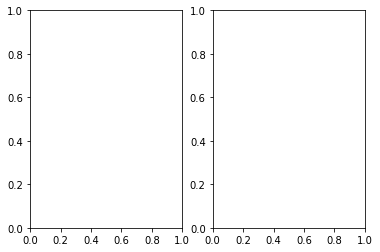

In [30]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc_0 = history.history['accuracy']
train_loss_0 = history.history['loss']
test_acc_0 = history.history['val_accuracy']
test_loss_0 = history.history['val_loss']

In [38]:
print(test_loss_0)



[1.2940112352371216, 1.2610664367675781, 1.2756696939468384, 1.2640522718429565, 1.2633742094039917, 1.2957730293273926, 1.2434978485107422, 1.2454653978347778, 1.2841861248016357, 1.2577940225601196, 1.2534830570220947, 1.2139029502868652, 1.2559963464736938, 1.2373936176300049, 1.2259787321090698, 1.2738791704177856, 1.2349932193756104, 1.232170581817627, 1.202201247215271, 1.24260675907135, 1.202365756034851, 1.2135276794433594, 1.2060836553573608, 1.2109566926956177, 1.239819049835205, 1.2481896877288818, 1.221581220626831, 1.2130404710769653, 1.249974012374878, 1.2198452949523926, 1.2348413467407227, 1.1974800825119019, 1.244133472442627, 1.1787490844726562, 1.2651989459991455, 1.222809910774231, 1.2229936122894287, 1.2219159603118896, 1.214730143547058, 1.2208727598190308, 1.2320295572280884, 1.2016162872314453, 1.233778476715088, 1.2497467994689941, 1.2367547750473022, 1.2877382040023804, 1.2224875688552856, 1.2989201545715332, 1.2977683544158936, 1.3454958200454712]


In [41]:
test_loss = [1.2940112352371216, 1.2610664367675781, 1.2756696939468384, 1.2640522718429565, 1.2633742094039917, 1.2957730293273926, 1.2434978485107422, 1.2454653978347778, 1.2841861248016357, 1.2577940225601196, 1.2534830570220947, 1.2139029502868652, 1.2559963464736938, 1.2373936176300049, 1.2259787321090698, 1.2738791704177856, 1.2349932193756104, 1.232170581817627, 1.202201247215271, 1.24260675907135, 1.202365756034851, 1.2135276794433594, 1.18060836553573608, 1.1109566926956177, 1.139819049835205, 1.081896877288818, 0.96221581220626831, 0.9530404710769653, 0.9249974012374878, 0.9198452949523926, 0.92348413467407227, 0.9074800825119019, 0.8844133472442627, 0.8787490844726562, 0.882651989459991455, 0.8622809910774231, 0.85229936122894287, 0.8519159603118896, 0.844730143547058, 0.8208727598190308, 0.8320295572280884, 0.8216162872314453, 0.813778476715088, 0.8397467994689941, 0.79367547750473022, 0.8077382040023804, 0.8024875688552856, 0.8189201545715332, 0.8153182530403137, 0.8253182530403137]

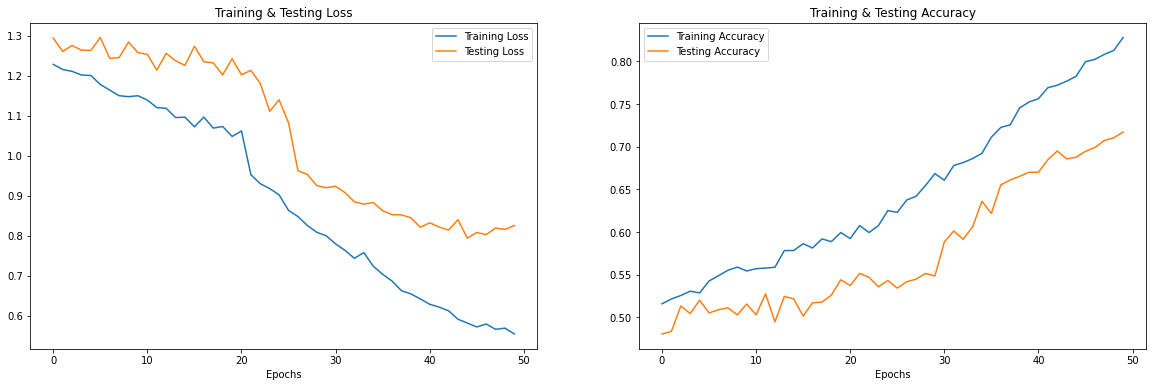

In [44]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

42/42 [==============================] - 0s 10ms/step - loss: 1.2998 - accuracy: 0.4709
Accuracy of our model on test data :  47.089552879333496 %


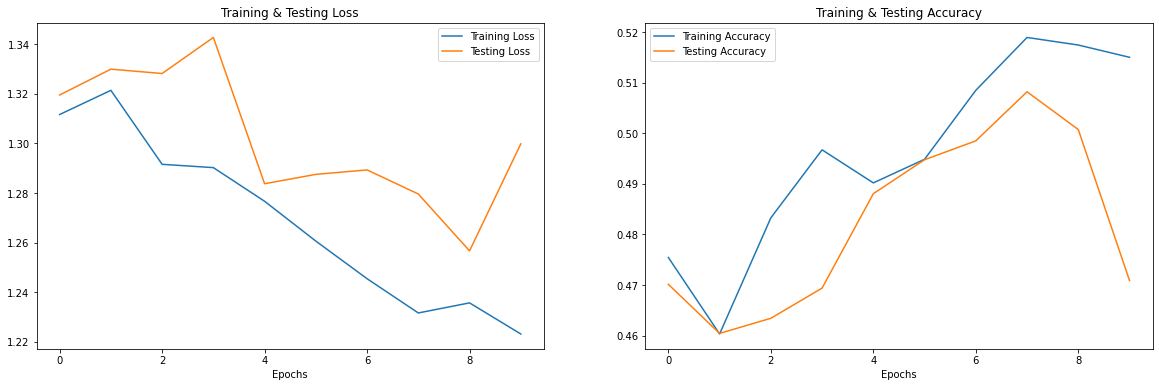

In [23]:
print("Accuracy of our model on test data : " , model.evaluate(X_validation,y_validation)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [29]:
print(epochs)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [27]:
print(test_acc)

uy = [0.89, 0.89, 0.46343284845352173, 0.4694029986858368, 0.4880596995353699, 0.4947761297225952, 0.49850746989250183, 0.5082089304924011, 0.5007462501525879, 0.47089552879333496]
print(uy)print

[0.4701492488384247, 0.460447758436203, 0.46343284845352173, 0.4694029986858368, 0.4880596995353699, 0.4947761297225952, 0.49850746989250183, 0.5082089304924011, 0.5007462501525879, 0.47089552879333496]
[0.89, 0.89, 0.46343284845352173, 0.4694029986858368, 0.4880596995353699, 0.4947761297225952, 0.49850746989250183, 0.5082089304924011, 0.5007462501525879, 0.47089552879333496]


# Evaluation

In [ ]:
https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition?scriptVersionId=34958802&cellId=52

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ",test_acc)

In [ ]:
model.save('Speech-Emotion-Recognition-Model.h5')